In [1]:
!pip install --upgrade hepml
!pip install arrow
!pip install keras_lr_finder
# reload modules before executing user code
#%load_ext autoreload
# reload all modules every time before executing Python code
#%autoreload 2
# render plots in notebook
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from hepml.core import plot_regression_tree
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!unzip drive/MyDrive/"jLab Shared Docs"/"MFC Modeling"/stanfordMFCDataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.9 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=3202ff3c8e64bf71f204cc6e4f75116b58e2c2a6a26e8d0b52092e980f836586
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d9758207

In [53]:
#Load teros data
import glob
teros_files = glob.glob("rocket4/TEROSoutput*.csv")
X = pd.DataFrame()
for f in teros_files:
  try:
    csv = pd.read_csv(f, index_col=False).dropna()
    X = pd.concat([X, csv])
  except:
    continue

In [54]:
#Load power data
power_files = glob.glob("rocket4/soil*.csv")
y = pd.DataFrame()
for f in sorted(power_files, key=lambda x: int(x.split('.')[0].split('_')[-1])):
#in power_files:
  try:
    csv = pd.read_csv(f, on_bad_lines='skip', skiprows=10).dropna(how='all')
    csv = csv.rename({'Unnamed: 0': 'timestamp'}, axis='columns')
    y = pd.concat([y,csv])
  except:
    continue
y["timestamp"] = y["timestamp"].round(decimals = 1)

In [55]:
#Convert current to amps, voltage to volts
y["I1L [10pA]"] = np.abs(y["I1L [10pA]"] * 10E-12)
y["V1 [10nV]"] = np.abs(y["V1 [10nV]"] * 10E-9)
y["I1H [nA]"] = np.abs(y["I1H [nA]"] * 10E-9)

In [56]:
#Sort data by timestamp, convert to datetime
X = X.sort_values(['timestamp'])
y = y.sort_values(['timestamp'])
X['timestamp'] = pd.to_datetime(X['timestamp'], unit='s')
y['timestamp'] = pd.to_datetime(y['timestamp'], unit='s')

#Merge data by timestamp
uncut_df = pd.merge_asof(left=X,right=y,direction='nearest',tolerance=pd.Timedelta('1 sec'), on = 'timestamp').dropna(how='all')

#Isolate data from cell0
df = uncut_df.loc[uncut_df['sensorID'] == 0]

#Localize timestamp
df.timestamp = df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

#Get time since deployement
df['tsd'] = (df['timestamp'] - df['timestamp'][840344]).dt.days

<ipython-input-56-82a78218b4d4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.timestamp = df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
<ipython-input-56-82a78218b4d4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tsd'] = (df['timestamp'] - df['timestamp'][840344]).dt.days


In [57]:
#Use only data from after deployment date
#df = df.loc[(df['timestamp'] > '2021-09-24') & (df['timestamp'] < '2021-10-15')] #Future of Clean Computing Graph
#df = df.loc[(df['timestamp'] > '2021-06-24') & (df['timestamp'] < '2021-07-02')]
df = df.loc[(df['timestamp'] > '2021-06-18')] #Two weeks after deployment
#df = df.loc[(df['timestamp'] > '2021-06-25') & (df['timestamp'] < '2021-06-26')] #Small training set

#Power drop
#df = df.loc[(df['timestamp'] > '2021-11-01') & (df['timestamp'] < '2021-11-22')]

#Calculate power
df["power"] = np.abs(np.multiply(df.iloc[:, 8], df.iloc[:, 9]))
#df["power"] = np.abs(np.multiply(df["I1L [10pA]"], df["V1 [10nV]"]))

df['power'] = df['power']*1E9

<ipython-input-57-3623f9981324>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["power"] = np.abs(np.multiply(df.iloc[:, 8], df.iloc[:, 9]))
<ipython-input-57-3623f9981324>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['power'] = df['power']*1E9


In [58]:
df["I1L [10pA]"] = np.abs(df["I1L [10pA]"] * 10E6)
df["V1 [10nV]"] = np.abs(df["V1 [10nV]"] * 10E3)
df["I1H [nA]"] = np.abs(df["I1H [nA]"] * 10E3)

<ipython-input-58-7cff2d179b25>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["I1L [10pA]"] = np.abs(df["I1L [10pA]"] * 10E6)
<ipython-input-58-7cff2d179b25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["V1 [10nV]"] = np.abs(df["V1 [10nV]"] * 10E3)


In [59]:
df = df.resample('60min', on='timestamp').mean().iloc[1: , :]

In [60]:
df = df.rolling('1h', on = df.index).mean().iloc[1: , :]

In [61]:
#Add power time series
df['power - 1h'] = df['power'].shift(1).dropna()
#df['power - 2h'] = df['power'].shift(2).dropna()
#df['previous_power - 3'] = df['power'].shift(3).dropna()
#df['previous_power - 4'] = df['power'].shift(4).dropna()

#Add teros time series
df['EC - 1h'] = df['EC'].shift(1).dropna()
df['temp - 1h'] = df['temp'].shift(1).dropna()
df['raw_VWC - 1h'] = df['raw_VWC'].shift(1).dropna()

#Add voltage and current time series
df['V1 - 1h'] = df['V1 [10nV]'].shift(1).dropna()
df['I1L - 1h'] = df['I1L [10pA]'].shift(1).dropna()
df['I1H - 1h'] = df['I1H [nA]'].shift(1).dropna()
df = df.dropna()

In [ ]:
#Drop data outages
df = df.drop(df[(df.index > '2021-11-11') & (df.index < '2021-11-22 01:00:00')].index)
df = df[:-1]

In [ ]:
#Add datetime features
#df['year'] = df['timestamp'].dt.isocalendar().year
#the month number, e.g. January = 1
#df['month'] = df['timestamp'].dt.month
#the calendar day, e.g. 13th May = 13
#df['day'] = df['timestamp'].dt.day
#the hour
#df['hour'] = df['timestamp'].dt.hour

In [46]:
#Re-split data for training
#X = pd.concat([df.iloc[:, 1:2], df.iloc[:, 15:16], df.iloc[:, 17:19], df.iloc[:, 11:15]], axis = 1)#.dropna()
#y = df.iloc[:, 10:11]#.dropna()

#Creating training and testing sets (without rolling)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 2:5], df.iloc[:, 13:14], df.iloc[:, 15:19]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(df.iloc[:, 14:15], test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 1:2], df.iloc[:, 17:18], df.iloc[:, 19:20], df.iloc[:, 3:4], df.iloc[:, 9:10], df.iloc[:, 13:17]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 12:13]], axis = 1), test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 17:21], df.iloc[:, 1:2], df.iloc[:, 21:22], df.iloc[:, 23:24], df.iloc[:, 2:3], df.iloc[:, 4:5], df.iloc[:, 10:11], df.iloc[:, 25:26], df.iloc[:, 15:16], df.iloc[:, 13:15], df.iloc[:, 24:25]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 16:17]], axis = 1), test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll, hour)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 15:19], df.iloc[:, 1:2], df.iloc[:, 19:20], df.iloc[:, 21:22], df.iloc[:, 2:3], df.iloc[:, 4:5], df.iloc[:, 10:11], df.iloc[:, 13:14], df.iloc[:, 22:23]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 14:15]], axis = 1), test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll, no hour)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 15:19], df.iloc[:, 2:3], df.iloc[:, 20:21], df.iloc[:, 23:24]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 14:15]], axis = 1), test_size=0.3, shuffle=False)
X = pd.concat([df["power - 1h"], df["V1 - 1h"], df["I1L - 1h"], df["EC - 1h"], df["raw_VWC - 1h"], df["temp - 1h"], df["tsd"]], axis = 1)
y = pd.concat([df["power"], df['V1 [10nV]'], df['I1L [10pA]']], axis = 1)

In [47]:
X = X.reset_index(drop=True).values
y = y.reset_index(drop=True).values

In [48]:
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
splits = TimeSeriesSplit(n_splits=9)
power_mape = []
voltage_mape = []
current_mape = []
for train_index, test_index in splits.split(X):
  #Split train and test sets
  X_train = X[train_index]
  X_test = X[test_index]
  y_train = y[train_index]
  y_test = y[test_index]
  print(len(train_index)/len(test_index))

  #reshape data
  X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
  X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

  # design network
  model = Sequential()
  model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(3))
  model.compile(loss='mape', optimizer='adam')

  batchsize = 18
  # fit network
  model.fit(X_train, y_train, epochs=20, batch_size=batchsize, verbose=2, shuffle=False)

  train_pred = model.predict(X_train, batch_size=batchsize)
  test_pred = model.predict(X_test, batch_size=batchsize)

  #Evaluate MAPE power
  print("Train MAPE power:\n", MAPE(y_train[:, 0], train_pred[:, 0]))
  print("Test MAPE power:\n", MAPE(y_test[:, 0], test_pred[:, 0]))

  #Evaluate MAPE voltage
  print("Train MAPE voltage:\n", MAPE(y_train[:, 1], train_pred[:, 1]))
  print("Test MAPE voltage:\n", MAPE(y_test[:, 1], test_pred[:, 1]))

  #Evaluate MAPE current
  print("Train MAPE current:\n", MAPE(y_train[:, 2], train_pred[:, 2]))
  print("Test MAPE current:\n", MAPE(y_test[:, 2], test_pred[:, 2]))

  power_mape.append(MAPE(y_test[:, 0], test_pred[:, 0]))
  voltage_mape.append(MAPE(y_test[:, 1], test_pred[:, 1]))
  current_mape.append(MAPE(y_test[:, 2], test_pred[:, 2]))

1.0168539325842696
Epoch 1/20
21/21 - 2s - loss: 62.3008 - 2s/epoch - 82ms/step
Epoch 2/20
21/21 - 0s - loss: 35.6629 - 83ms/epoch - 4ms/step
Epoch 3/20
21/21 - 0s - loss: 29.6625 - 93ms/epoch - 4ms/step
Epoch 4/20
21/21 - 0s - loss: 27.2748 - 81ms/epoch - 4ms/step
Epoch 5/20
21/21 - 0s - loss: 24.8475 - 100ms/epoch - 5ms/step
Epoch 6/20
21/21 - 0s - loss: 22.3534 - 90ms/epoch - 4ms/step
Epoch 7/20
21/21 - 0s - loss: 20.3337 - 94ms/epoch - 4ms/step
Epoch 8/20
21/21 - 0s - loss: 22.0031 - 91ms/epoch - 4ms/step
Epoch 9/20
21/21 - 0s - loss: 18.6411 - 96ms/epoch - 5ms/step
Epoch 10/20
21/21 - 0s - loss: 19.0437 - 97ms/epoch - 5ms/step
Epoch 11/20
21/21 - 0s - loss: 17.7815 - 98ms/epoch - 5ms/step
Epoch 12/20
21/21 - 0s - loss: 16.9060 - 88ms/epoch - 4ms/step
Epoch 13/20
21/21 - 0s - loss: 17.0502 - 88ms/epoch - 4ms/step
Epoch 14/20
21/21 - 0s - loss: 16.1042 - 81ms/epoch - 4ms/step
Epoch 15/20
21/21 - 0s - loss: 15.6109 - 102ms/epoch - 5ms/step
Epoch 16/20
21/21 - 0s - loss: 17.4077 - 90m

(0.0, 0.6)

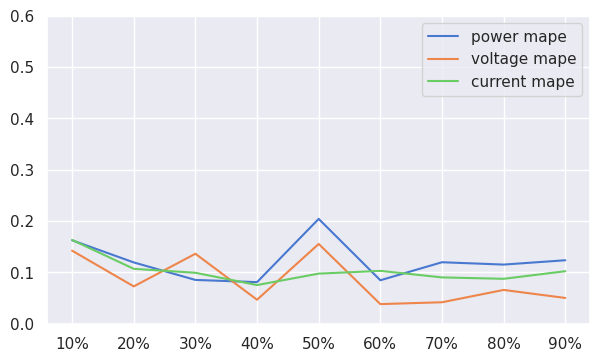

In [49]:
import matplotlib.ticker as mtick

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)


t = np.arange(1, 10) * 10
ax.plot(t, np.c_[power_mape, voltage_mape, current_mape], label=['power mape', 'voltage mape', 'current mape']);
plt.legend();

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)

ax.set_ylim(0, 0.6)

In [51]:
df

,sensorID,raw_VWC,temp,EC,I1L_valid,I2L_valid,I1H [nA],I1L [10pA],V1 [10nV],V2 [10nV],...,I2L [10pA],tsd,power,power - 1h,EC - 1h,temp - 1h,raw_VWC - 1h,V1 - 1h,I1L - 1h,I1H - 1h
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-21 13:00:00-07:00,0.0,2489.510492,30.135985,229.795455,1.0,1.0,3.142128,223.439853,770.964687,-4.624688e+06,...,3.056341e+06,0.0,1713.556321,1707.297550,230.590909,30.975758,2486.461667,891.331314,192.348231,2.373069
2021-06-21 14:00:00-07:00,0.0,2492.008897,29.340684,228.551331,1.0,1.0,3.878484,246.563645,672.071432,-4.107527e+06,...,2.803198e+06,0.0,1657.393367,1713.556321,229.795455,30.135985,2489.510492,770.964687,223.439853,3.142128
2021-06-21 15:00:00-07:00,0.0,2494.291212,28.567803,227.094697,1.0,1.0,4.286620,244.376587,599.703486,-3.709883e+06,...,2.061264e+06,0.0,1438.495990,1657.393367,228.551331,29.340684,2492.008897,672.071432,246.563645,3.878484
2021-06-21 16:00:00-07:00,0.0,2496.541818,27.871212,227.170455,1.0,1.0,3.997649,267.480179,548.710656,-3.392292e+06,...,2.235990e+06,0.0,1460.677195,1438.495990,227.094697,28.567803,2494.291212,599.703486,244.376587,4.286620
2021-06-21 17:00:00-07:00,0.0,2498.371749,27.298099,225.315589,1.0,1.0,3.921021,253.983449,508.005800,-3.134217e+06,...,2.011312e+06,0.0,1285.123753,1460.677195,227.170455,27.871212,2496.541818,548.710656,267.480179,3.997649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27 19:00:00-08:00,0.0,2695.337045,10.548106,217.628788,1.0,1.0,5.738337,222.336954,141.396883,-3.997810e+06,...,1.105493e+05,220.0,309.184521,257.279436,216.752852,9.775285,2692.370304,137.658867,188.822504,6.073694
2022-01-27 20:00:00-08:00,0.0,2698.127765,10.325379,216.257576,1.0,1.0,5.612758,217.049998,136.364915,-4.445531e+06,...,5.993731e+05,220.0,283.561699,309.184521,217.628788,10.548106,2695.337045,141.396883,222.336954,5.738337
2022-01-27 21:00:00-08:00,0.0,2697.993118,10.384411,217.615970,1.0,1.0,5.933845,176.277291,143.467903,-4.461138e+06,...,6.542789e+05,220.0,248.878492,283.561699,216.257576,10.325379,2698.127765,136.364915,217.049998,5.612758


In [ ]:
print(sum(power_mape) / len(power_mape))
print(sum(voltage_mape) / len(voltage_mape))
print(sum(current_mape) / len(current_mape))

0.378423852181619
0.3784860140379798
0.10790797987554766


In [ ]:
#Define SMAPE
def SMAPE(actual, predicted):
    return 1/len(actual) * np.sum(2 * np.abs(predicted-actual) / (np.abs(actual) + np.abs(predicted))*100)

In [ ]:
#reshape data
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# design network
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(3))
model.compile(loss='mape', optimizer='adam')

In [ ]:
from keras_lr_finder import LRFinder
# model is a Keras model
lr_finder = LRFinder(model)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(X_train, y_train, start_lr=0.0001, end_lr=10, batch_size=512, epochs=6)

Epoch 1/6
1383/1383 [==============================] - 13s 7ms/step - loss: 477.6351
Epoch 2/6
1383/1383 [==============================] - 11s 8ms/step - loss: 450.8291
Epoch 3/6
1383/1383 [==============================] - 16s 11ms/step - loss: 336.5304
Epoch 4/6
1383/1383 [==============================] - 10s 7ms/step - loss: 220.3073
Epoch 5/6
1383/1383 [==============================] - 10s 7ms/step - loss: 200.5687
Epoch 6/6
1383/1383 [==============================] - 11s 8ms/step - loss: 247.2008


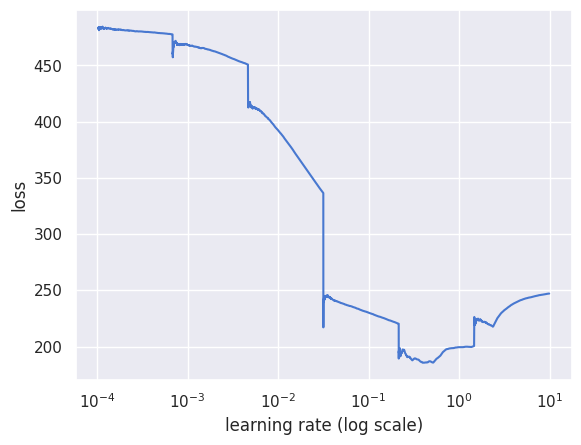

In [ ]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [ ]:
!pip install -U numpy==1.18.5

In [ ]:
from keras import backend as K
#K.set_value(model.optimizer.learning_rate, 0.3)

batchsize = 18
# fit network
model.fit(X_train, y_train, epochs=20, batch_size=batchsize, verbose=2, shuffle=False)


Epoch 1/20
1023/1023 - 7s - loss: 15.5108 - 7s/epoch - 7ms/step
Epoch 2/20
1023/1023 - 6s - loss: 7.1860 - 6s/epoch - 6ms/step
Epoch 3/20
1023/1023 - 5s - loss: 5.9099 - 5s/epoch - 5ms/step
Epoch 4/20
1023/1023 - 8s - loss: 5.3296 - 8s/epoch - 7ms/step
Epoch 5/20
1023/1023 - 5s - loss: 4.5943 - 5s/epoch - 5ms/step
Epoch 6/20
1023/1023 - 5s - loss: 4.9008 - 5s/epoch - 4ms/step
Epoch 7/20
1023/1023 - 6s - loss: 4.3204 - 6s/epoch - 6ms/step
Epoch 8/20
1023/1023 - 4s - loss: 4.3870 - 4s/epoch - 4ms/step
Epoch 9/20
1023/1023 - 4s - loss: 4.6399 - 4s/epoch - 4ms/step
Epoch 10/20
1023/1023 - 7s - loss: 3.9823 - 7s/epoch - 6ms/step
Epoch 11/20
1023/1023 - 5s - loss: 3.8555 - 5s/epoch - 4ms/step
Epoch 12/20
1023/1023 - 7s - loss: 3.7445 - 7s/epoch - 7ms/step
Epoch 13/20
1023/1023 - 7s - loss: 3.7791 - 7s/epoch - 6ms/step
Epoch 14/20
1023/1023 - 5s - loss: 3.8024 - 5s/epoch - 5ms/step
Epoch 15/20
1023/1023 - 9s - loss: 3.6959 - 9s/epoch - 9ms/step
Epoch 16/20
1023/1023 - 7s - loss: 3.4849 - 7s/e

In [ ]:
model.save("lstm_30min", overwrite=True, save_format=None)

In [ ]:
!mv lstm_30min 'drive/MyDrive/jLab Shared Docs/MFC Modeling'

In [ ]:
from keras_lr_finder import LRFinder
# model is a Keras model
lr_finder = LRFinder(model)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(X_train, y_train, start_lr=0.0001, end_lr=1, batch_size=512, epochs=5)

Epoch 1/5
1383/1383 [==============================] - 11s 8ms/step - loss: 42.0569
Epoch 2/5
1383/1383 [==============================] - 10s 7ms/step - loss: 38.8623
Epoch 3/5
1383/1383 [==============================] - 10s 8ms/step - loss: 54.7279
Epoch 4/5
1383/1383 [==============================] - 10s 7ms/step - loss: 85.0554
Epoch 5/5
1383/1383 [==============================] - 10s 8ms/step - loss: 87.3932


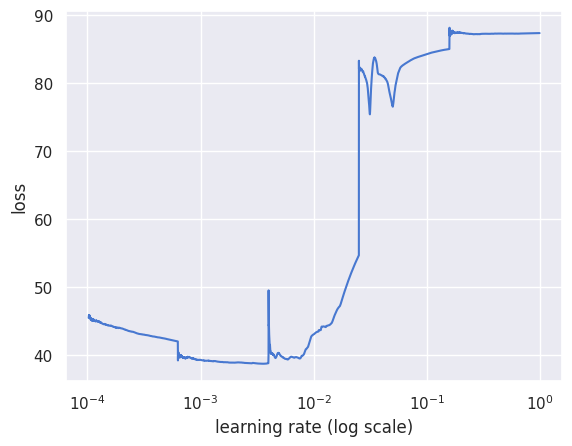

In [ ]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
train_pred = model.predict(X_train, batch_size=batchsize)
test_pred = model.predict(X_test, batch_size=batchsize)

1534/1534 [==============================] - 10s 6ms/step


In [ ]:
y_train

,power,V1 [10nV],I1L [10pA]
timestamp,,,
2021-06-21 11:25:00-07:00,1540.283104,915.287393,159.515921
2021-06-21 11:30:00-07:00,1565.117849,948.486201,158.836415
2021-06-21 11:35:00-07:00,1566.647996,979.510251,156.328818
2021-06-21 11:40:00-07:00,1592.579653,1002.552448,156.576172
2021-06-21 11:45:00-07:00,1617.058700,1025.352560,157.303444
...,...,...,...
2021-10-13 04:50:00-07:00,470.489637,230.556085,206.539972
2021-10-13 04:55:00-07:00,471.200443,229.796365,207.570490
2021-10-13 05:00:00-07:00,478.045636,228.875178,211.483802


In [ ]:
train_pred

array([[1550.2512 ,  852.8913 ,  159.65053],
       [1590.5591 ,  882.81134,  160.07521],
       [1619.4214 ,  914.918  ,  158.24434],
       ...,
       [ 480.20694,  235.97131,  207.8695 ],
       [ 486.98386,  234.64207,  212.15208],
       [ 481.8149 ,  234.33087,  210.27222]], dtype=float32)

In [ ]:
#Evaluate SMAPE
#print("Train SMAPE:\n", SMAPE(y_train.values.ravel(), train_pred))
#print("Test SMAPE:\n", SMAPE(y_test.values.ravel(), test_pred))

#Evaluate MAPE
print("Train MAPE power:\n", MAPE(y_train['power'].values.ravel(), train_pred[:, 0]))
print("Test MAPE power:\n", MAPE(y_test['power'].values.ravel(), test_pred[:, 0]))

#print("Train MAPE power:\n", MAPE(y_train['power'].shift(1).dropna().values.ravel(), train_pred[:, 0][1:]))
#print("Test MAPE power:\n", MAPE(y_test['power'].shift(1).dropna().values.ravel(), test_pred[:, 0][1:]))

#Evalaute MAE
print("Train MAE power:\n", mean_absolute_error(y_train['power'].values.ravel(), train_pred[:, 0]))
print("Test MAE power:\n", mean_absolute_error(y_test['power'].values.ravel(), test_pred[:, 0]))

Train MAPE power:
 0.04112260203500509
Test MAPE power:
 0.6959302259631488
Train MAE power:
 21.886273740813685
Test MAE power:
 36.963306622464586


In [ ]:
#Evaluate MAPE
print("Train MAPE voltage:\n", MAPE(y_train['V1 [10nV]'].values.ravel(), train_pred[:, 1]))
print("Test MAPE voltage:\n", MAPE(y_test['V1 [10nV]'].values.ravel(), test_pred[:, 1]))

#print("Train MAPE voltage:\n", MAPE(y_train['V1 [10nV]'].shift(1).dropna().values.ravel(), train_pred[:, 1][1:]))
#print("Test MAPE voltage:\n", MAPE(y_test['V1 [10nV]'].shift(1).dropna().values.ravel(), test_pred[:, 1][1:]))

#Evalaute MAE
print("Train MAE voltage:\n", mean_absolute_error(y_train['V1 [10nV]'].values.ravel(), train_pred[:, 1]))
print("Test MAE voltage:\n", mean_absolute_error(y_test['V1 [10nV]'].values.ravel(), test_pred[:, 1]))

Train MAPE voltage:
 0.033086016360312415
Test MAPE voltage:
 0.972538369007135
Train MAE voltage:
 10.47202434790737
Test MAE voltage:
 28.972905840031043


In [ ]:
#Evaluate MAPE
print("Train MAPE current:\n", MAPE(y_train['I1L [10pA]'].values.ravel(), train_pred[:, 2]))
print("Test MAPE current:\n", MAPE(y_test['I1L [10pA]'].values.ravel(), test_pred[:, 2]))

#print("Train MAPE current:\n", MAPE(y_train['I1L [10pA]'].shift(1).dropna().values.ravel(), train_pred[:, 2][1:]))
#print("Test MAPE current:\n", MAPE(y_test['I1L [10pA]'].shift(1).dropna().values.ravel(), test_pred[:, 2][1:]))

#Evalaute MAE
print("Train MAE current:\n", mean_absolute_error(y_train['I1L [10pA]'].values.ravel(), train_pred[:, 2]))
print("Test MAE current:\n", mean_absolute_error(y_test['I1L [10pA]'].values.ravel(), test_pred[:, 2]))

Train MAPE current:
 0.03577720777148524
Test MAPE current:
 0.059244584192332625
Train MAE current:
 5.861255325509229
Test MAE current:
 14.964420144702359


In [ ]:
y_train['I1L [10pA]'].diff().min()

-192.79895000000002

In [ ]:
y_train['V1 [10nV]'].diff().min()

-647.5048632575757

In [ ]:
y_train['power'].diff().min()

-948.89687981835

In [ ]:
predictions = model.predict(np.concatenate((X_train, X_test)))

120/120 [==============================] - 0s 2ms/step


In [ ]:
mv1 = df
mv1["power_pred"] = predictions[:, 0]
mv1["voltage_pred"] = predictions[:, 1]
mv1["current_pred"] = predictions[:, 2]
mv1 = mv1.loc[(mv1.index > '2021-12-12') & (mv1.index < '2021-12-14')]
mv2 = mv1

<ipython-input-127-e78f9a62da96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mv1["power_pred"] = predictions[:, 0]
<ipython-input-127-e78f9a62da96>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mv1["voltage_pred"] = predictions[:, 1]
<ipython-input-127-e78f9a62da96>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [ ]:
df.iloc[1915:2298]

NameError: ignored

In [ ]:
mv1 = mv1.loc[(mv1.index > '2021-1-12') & (mv1.index < '2021-12-14')]

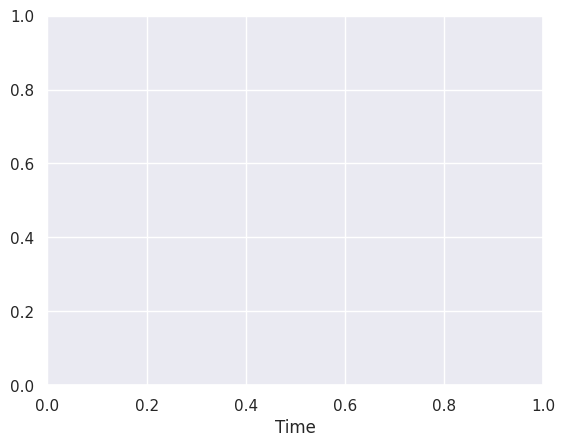

In [ ]:
import matplotlib as mpl
mpl.use('Agg')
#mpl.rc('font', **font)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as md
import datetime
import numpy as np
from pytz import timezone
import pandas as pd
import arrow
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# Limits for graphs
VOLTAGE_LIM = 0.2
CURRENT_LIM = 40
POWER_LIM = 4




plt.close()
plt.xlabel("Time")
fig, (ax1, ax3) = plt.subplots(2,figsize=(4,2), sharex=True)
fig.autofmt_xdate()


volt_color= 'tab:blue'

amp_color = 'tab:red'


volt_color1= 'tab:blue'
volt_style1 = 'dashed'
volt_color2= 'tab:green'
volt_style2 = 'dotted'
amp_color1 = 'tab:red'
amp_style1='dashed'
amp_color2 = 'tab:orange'
amp_style2='dashdot'


ax3.fmt_xdata = md.DateFormatter('%m-%d')
ax3.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
#ax3.set_ylabel("Power (uW)")
ax3.set_ylabel("Current")
ax3.grid(True)
#print('max power: ',max(max(1E6*df['power1']),max(1E6*df['power2'])))
#ax3.set_ylim(0, 4)
ax3.plot(mv1.index, 1E6*mv2["current_pred"], color=volt_color1, ls = volt_style1)
ax3.plot(mv1.index, 1E6*mv2['I1L [10pA]'], color=volt_color2, ls = volt_style2)
ax3.legend(['predictions','actual'], loc='upper right', prop={'size': 6})

#Plot error
#ax3.plot(mv1['timestamp'], mv1['error']/mv1['power'], color=volt_color2, ls = volt_style2)
#ax3.legend(['error'], loc='upper right', prop={'size': 6})

ax3.tick_params(axis='x', labelsize=6, rotation=0)
#ax3.xaxis.set_major_locator(plt.MaxNLocator(6))
#ax3.set_xlim(mv.index[0], datetime.date(2020,5,19))
for label in ax3.get_xticklabels():
    label.set_horizontalalignment('center')

plt.tight_layout(pad=0.6, w_pad=0.5, h_pad=0.6)
plt.subplots_adjust(hspace=0.15)
plt.savefig('twobat.pdf')
plt.close()
#tot_energy = np.trapz(df['power1'])
#tot_energy = np.trapz(df['power2'])
#print(tot_energy)